
# 2.2-kW induction motor, saturated

This example simulates sensorless current-vector control of a 2.2-kW induction
motor drive. The magnetic saturation of the machine is also included in the
system model, while the control system assumes constant parameters.


In [1]:
pip install motulator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 1.8 MB/s eta 0:00:00


In [2]:
from motulator.drive import model
import motulator.drive.control.im as control
from motulator.drive.utils import (
    BaseValues, NominalValues, plot, InductionMachinePars,
    InductionMachineInvGammaPars)

Compute base values based on the nominal values (just for figures).



In [3]:
nom = NominalValues(U=400, I=5, f=50, P=2.2e3, tau=14.6)
base = BaseValues.from_nominal(nom, n_p=2)

The main-flux saturation in the system model is modeled based on [#Qu2012]_.
The default parameters correspond to the measured data of a 2.2-kW machine.



In [4]:
def L_s(psi, L_su=.34, beta=.84, S=7):
    """Stator inductance saturation model."""
    return L_su/(1 + (beta*psi)**S)

Configure the system model.



In [5]:
# Γ-equivalent machine model with main-flux saturation included
mdl_par = InductionMachinePars(n_p=2, R_s=3.7, R_r=2.5, L_ell=.023, L_s=L_s)
# Unsaturated machine model, using its inverse-Γ parameters (uncomment to try)
# par = InductionMachineInvGammaPars(
#     n_p=2, R_s=3.7, R_R=2.1, L_sgm=.021, L_M=.224)
# mdl_par = InductionMachinePars.from_inv_gamma_model_pars(par)
machine = model.InductionMachine(mdl_par)
mechanics = model.StiffMechanicalSystem(J=.015)
converter = model.VoltageSourceConverter(u_dc=540)
mdl = model.Drive(converter, machine, mechanics)
# mdl.pwm = model.CarrierComparison()  # Try to enable the PWM model
# mdl.delay = model.Delay(2)  # Try longer computational delay

Configure the control system.



In [6]:
# Machine model parameter estimates
par = InductionMachineInvGammaPars(
    n_p=2, R_s=3.7, R_R=2.1, L_sgm=.021, L_M=.224)
# Set nominal values and limits for reference generation
cfg = control.CurrentReferenceCfg(
    par, max_i_s=1.5*base.i, nom_u_s=base.u, nom_w_s=base.w)
# Create the control system
ctrl = control.CurrentVectorControl(
    par, cfg, J=.015, T_s=250e-6, sensorless=True)
# As an example, you may replace the default 2DOF PI speed controller with the
# regular PI speed controller by uncommenting the following line
# from motulator.common.control import PIController
# ctrl.speed_ctrl = PIController(k_p=1, k_i=1)

Set the speed reference and the external load torque. You may also try to
uncomment the field-weakening sequence.



In [7]:
# Simple acceleration and load torque step
ctrl.ref.w_m = lambda t: (t > .2)*(.5*base.w)
mdl.mechanics.tau_L = lambda t: (t > .75)*nom.tau

# No load, field-weakening (uncomment to try)
# ctrl.ref.w_m = lambda t: (t > .2)*(2*base.w)
# mdl.mechanics.tau_L = lambda t: 0

Create the simulation object and simulate it.



In [8]:
sim = model.Simulation(mdl, ctrl)
sim.simulate(t_stop=1.5)

Plot results in per-unit values. By omitting the argument `base` you can plot
the results in SI units.



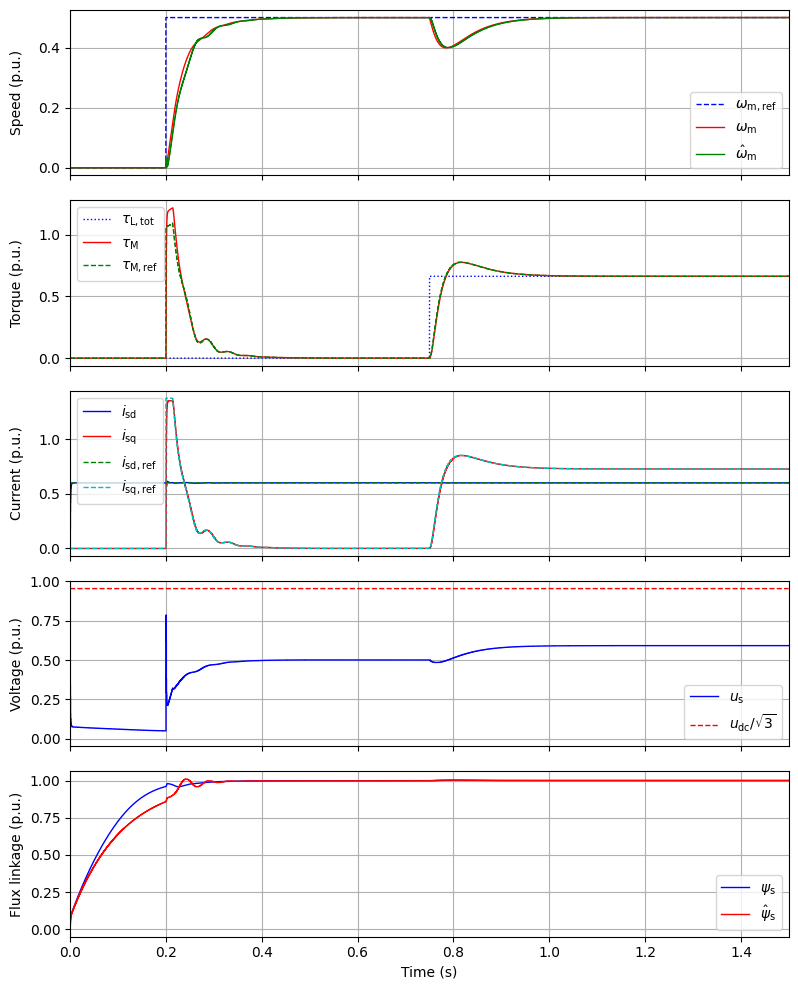

In [9]:
plot(sim, base)

.. rubric:: References

.. [#Qu2012] Qu, Ranta, Hinkkanen, Luomi, "Loss-minimizing flux level control
   of induction motor drives," IEEE Trans. Ind. Appl., 2012,
   https://doi.org/10.1109/TIA.2012.2190818

